<a href="https://colab.research.google.com/github/kushal-h/Deep-Learning-Implementations/blob/master/CNN/Plant_disease_detection_38_category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **@Author: Kushal H**

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kushalh","key":"ff7cbaa4c5674ba7ebf5f4a310ad48a4"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

100% 2.03G/2.04G [00:15<00:00, 96.3MB/s]
100% 2.04G/2.04G [00:15<00:00, 139MB/s] 


Unziping the dataset

In [ ]:
!unzip /content/plantvillage-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

Import neccessary packages

In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
directory_root = '/content/plantvillage dataset/segmented'
width=64
height=64
depth=3

Function to convert images to numpy array

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [ ]:
root_dir = listdir(directory_root)
len(root_dir)

38

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
     
    for disease_folder in root_dir :
        # remove .DS_Store from list
        if disease_folder == ".DS_Store" :
            root_dir.remove(disease_folder)

    for plant_disease_folder in root_dir:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        root_dir = listdir(f"{directory_root}/{plant_disease_folder}/")
            
        for single_plant_disease_image in root_dir :
            if single_plant_disease_image == ".DS_Store" :
                root_dir.remove(single_plant_disease_image)

        for image in root_dir:
            image_directory = f"{directory_root}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Strawberry___Leaf_scorch ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Raspberry___healthy ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Processing Soybean___healthy ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INF

Get Size of Processed Image

In [ ]:
image_size = len(image_list)
image_size

54306

Transform Image Labels uisng Scikit Learn's LabelBinarizer

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

Analyzing the image lables transformed

In [ ]:
label_binarizer

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [ ]:
label_binarizer.classes_

array(['Apple___Apple_scab', 'Apple___Black_rot',
       'Apple___Cedar_apple_rust', 'Apple___healthy',
       'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew',
       'Cherry_(including_sour)___healthy',
       'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
       'Corn_(maize)___Common_rust_',
       'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy',
       'Grape___Black_rot', 'Grape___Esca_(Black_Measles)',
       'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
       'Orange___Haunglongbing_(Citrus_greening)',
       'Peach___Bacterial_spot', 'Peach___healthy',
       'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
       'Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy',
       'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch',
       'Strawberry___healthy', 'Tomato___Bacterial_spot',
       'Tomato___Early_blight', 'Tomato___Late_blight',
   

In [ ]:
image_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
label_list[0]

'Tomato___Leaf_Mold'

In [ ]:
image_list[0]

array([[[161., 165., 153.],
        [186., 190., 178.],
        [192., 196., 184.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[171., 175., 163.],
        [196., 200., 188.],
        [201., 205., 193.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[168., 172., 160.],
        [198., 202., 190.],
        [207., 211., 199.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       ...,

       [[173., 181., 170.],
        [202., 210., 199.],
        [198., 206., 195.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[177., 185., 175.],
        [206., 214., 204.],
        [205., 213., 203.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[164., 171., 164.],
        [193., 200., 193.],
        [198., 2

In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [ ]:
np_image_list[0]

array([[[0.6313, 0.647 , 0.6   ],
        [0.7295, 0.745 , 0.698 ],
        [0.753 , 0.7686, 0.7217],
        ...,
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ]],

       [[0.6704, 0.686 , 0.639 ],
        [0.7686, 0.784 , 0.7373],
        [0.788 , 0.8037, 0.757 ],
        ...,
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ]],

       [[0.6587, 0.6743, 0.6274],
        [0.7764, 0.792 , 0.745 ],
        [0.8115, 0.8276, 0.7803],
        ...,
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ]],

       ...,

       [[0.678 , 0.71  , 0.6665],
        [0.792 , 0.8237, 0.7803],
        [0.7764, 0.8076, 0.7646],
        ...,
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    ]],

       [[0.6943, 0.7256, 0.686 ],
        [0.8076, 0.8394, 0.8   ],
        [0.8037, 0.8354, 0.796 ],
        .

Enumerating categorical value 

In [ ]:
categories ={v : k for v, k in enumerate(label_binarizer.classes_)}
categories

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

Spliting data into 80% training data and 20% test data

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
len(y_test)

10862

In [ ]:
len(y_train)

43444

Image augmentation

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
x_train[0].shape

(64, 64, 3)

Building the model

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 64)        0

Compiling the model

In [ ]:
opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


Creating early stop to stop the training when deserved output is achieved

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 2,
                          verbose = 1,
                          restore_best_weights = True)

Fitting the model (training)

In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    callbacks=earlystop,
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
1357/1357 [==============================] - 635s 468ms/step - loss: 0.0467 - accuracy: 0.6905 - val_loss: 0.0371 - val_accuracy: 0.7558
Epoch 2/25
1357/1357 [==============================] - 637s 470ms/step - loss: 0.0355 - accuracy: 0.7727 - val_loss: 0.0344 - val_accuracy: 0.7834
Epoch 3/25
1357/1357 [==============================] - 632s 466ms/step - loss: 0.0292 - accuracy: 0.8177 - val_loss: 0.0342 - val_accuracy: 0.7844
Epoch 4/25
1357/1357 [==============================] - 629s 464ms/step - loss: 0.0252 - accuracy: 0.8421 - val_loss: 0.0332 - val_accuracy: 0.7948
Epoch 5/25
1357/1357 [==============================] - 621s 457ms/step - loss: 0.0220 - accuracy: 0.8649 - val_loss: 0.0368 - val_accuracy: 0.7770
Epoch 6/25
1357/1357 [==============================] - 618s 456ms/step - loss: 0.0195 - accuracy: 0.8830 - val_loss: 0.0294 - val_accuracy: 0.8279
Epoch 7/25
Epoch 7/25
1357/1357 [==============================] - 637s 469ms/step - loss: 0.0183 - accuracy: 0.

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
340/340 [==============================] - 36s 106ms/step - loss: 0.0137 - accuracy: 0.9289
Test Accuracy: 92.89265275001526


Saving model

In [ ]:
model.save('models.h5')

Model architecture 

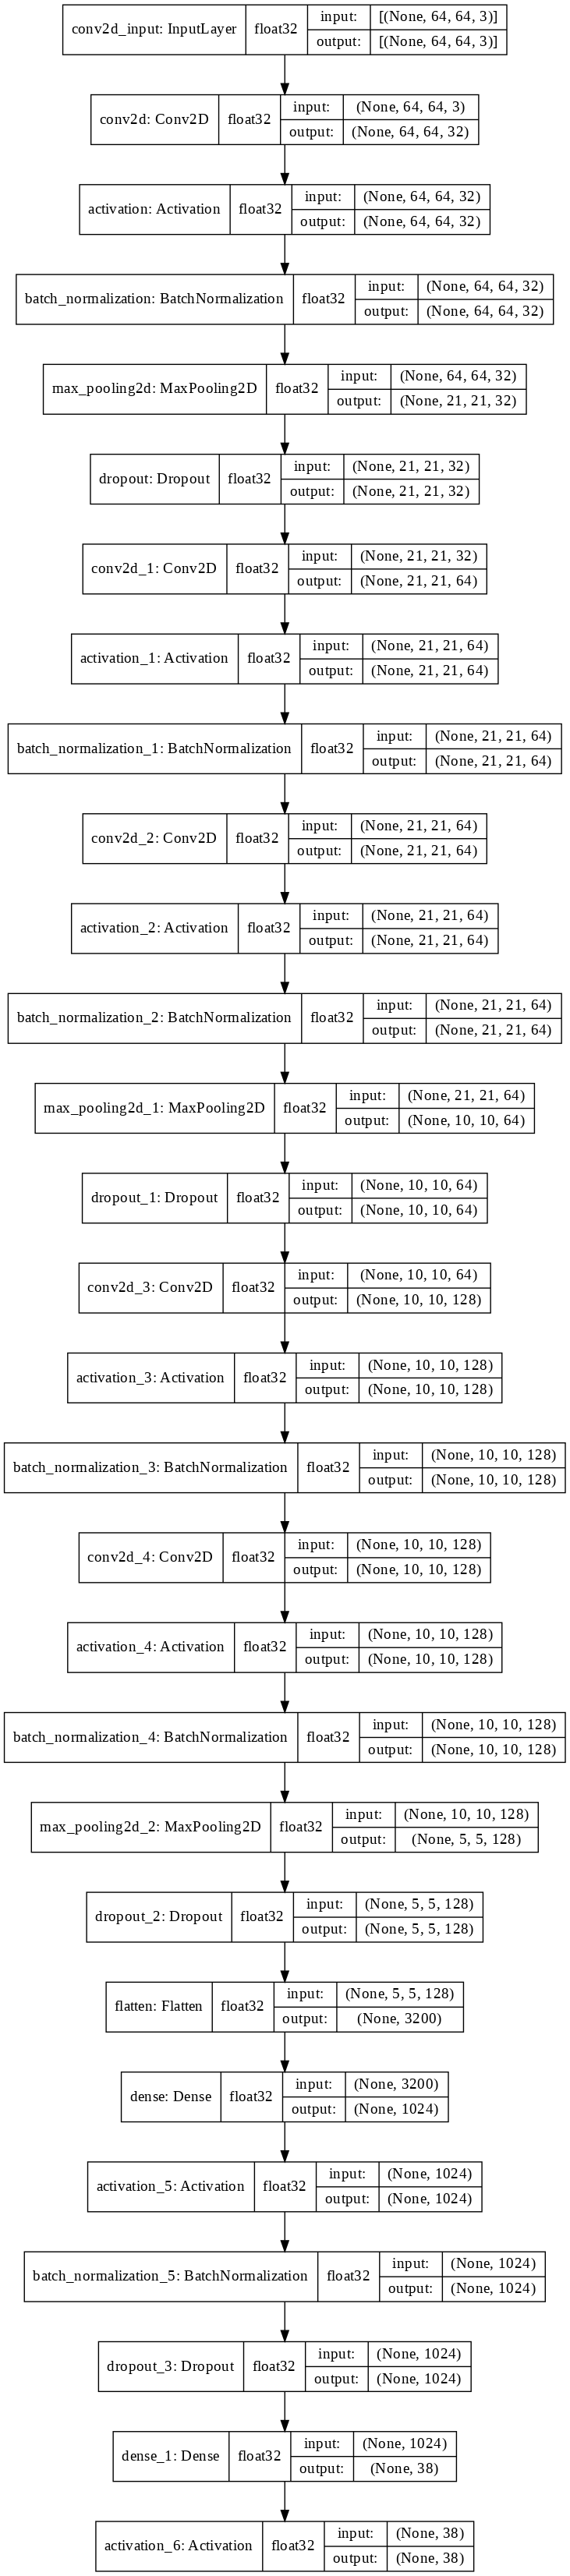

In [ ]:
tf.keras.utils.plot_model(model, to_file = 'plant.png',  show_shapes = True, show_dtype = True, 
                          show_layer_names = True, rankdir='TB', expand_nested = True,dpi=100)

Plotting graph

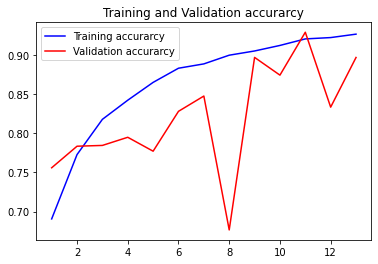

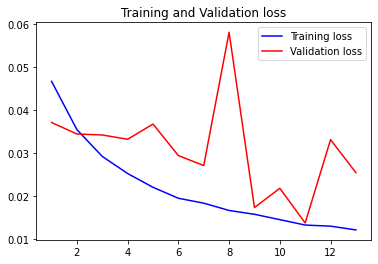

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Prediction

Loading model

In [ ]:
model = tf.keras.models.load_model("/content/weights.h5")

In [ ]:
result=model.predict(x_test)

In [ ]:
value=np.argmax(result,axis=1)

In [ ]:
value[1001] #predicting value

15

In [ ]:
real_value= y_test[1001]

In [ ]:
real_value

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
np.argmax(real_value) #real value

15